# Data prep

Based on [a Notebook from kaggle](https://www.kaggle.com/pmarcelino/comprehensive-data-exploration-with-python)

## Imports

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats

%matplotlib inline

## Import datasets

In [2]:
df_train = pd.read_csv('./sources/train.csv')
df_test = pd.read_csv('./sources/test.csv')

## Data viz

### Check columns

In [3]:
df_train.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

### SalePrice

In [4]:
# descriptive statistics summary

df_train['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

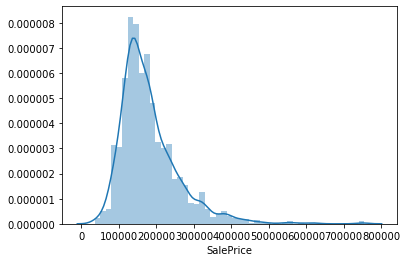

In [5]:
# histogram

sns.distplot(df_train['SalePrice'])

In [6]:
#skewness and kurtosis

print("Skewness: %f" % df_train['SalePrice'].skew())
print("Kurtosis: %f" % df_train['SalePrice'].kurt())

Skewness: 1.882876
Kurtosis: 6.536282


#### Relations between SalePrice and most interesting Numerical features (TotalBsmtSF & GrLivArea)

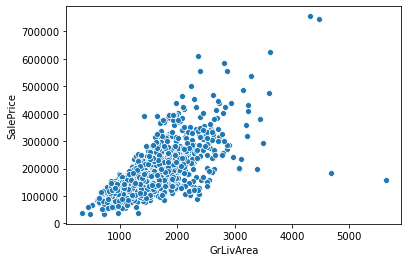

In [8]:
# Against GrLivArea

sns.scatterplot(x=df_train['GrLivArea'], y=df_train['SalePrice'])

We can see at least two outlayers with a high GrLivArea for a low SalePrice

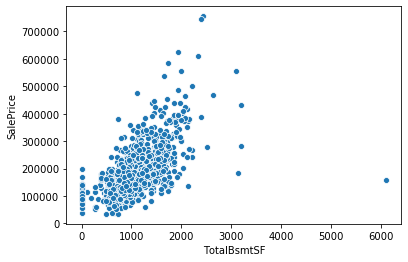

In [9]:
# Against TotalBsmtSF

sns.scatterplot(x=df_train['TotalBsmtSF'], y=df_train['SalePrice'])

We can see at least one outlaer with a great TotalBsmtSF and a low SalePrice. <br />
Also that a 0 TotalBsmtSF can have SalePrice

#### Relation between SalePrice and most interesting Categorical features

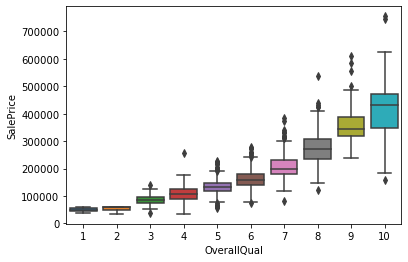

In [10]:
# Against OverallQual

sns.boxplot(x='OverallQual', y='SalePrice', data=df_train)

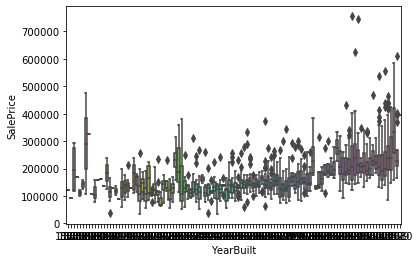

In [11]:
# Against YearBuilt

sns.boxplot(x='YearBuilt', y='SalePrice', data=df_train)

#### The others...

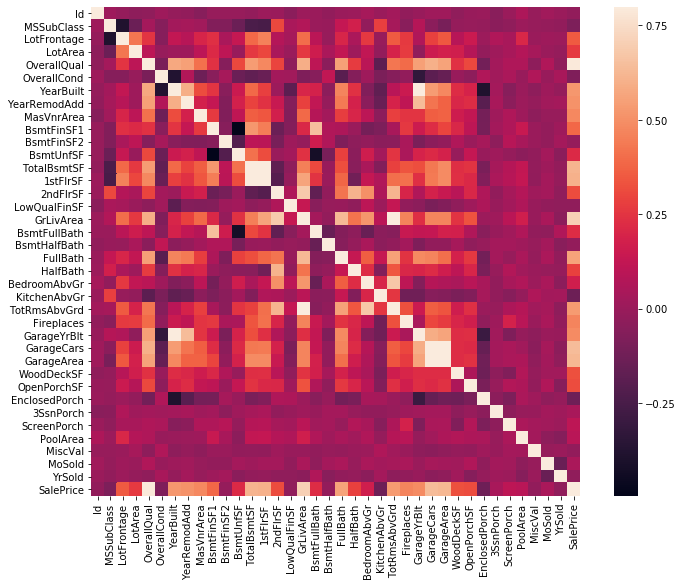

In [12]:
# Correlation Matrix

cormat = df_train.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(cormat, vmax=.8, square=True)

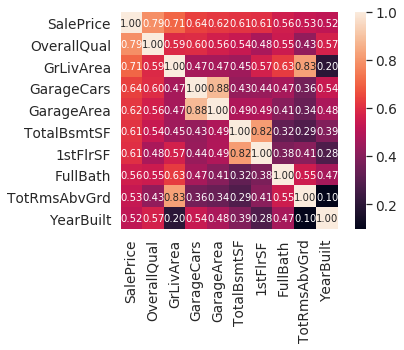

In [13]:
# saleprice correlation matrix

k = 10  # number of variables for heatmap
cols = cormat.nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(df_train[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={
                 'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

GarageCar & GarageArea and TotalBsmtSF & 1stFlrSF are strongly correlated two by two so we may want to keep just one feature of each couple

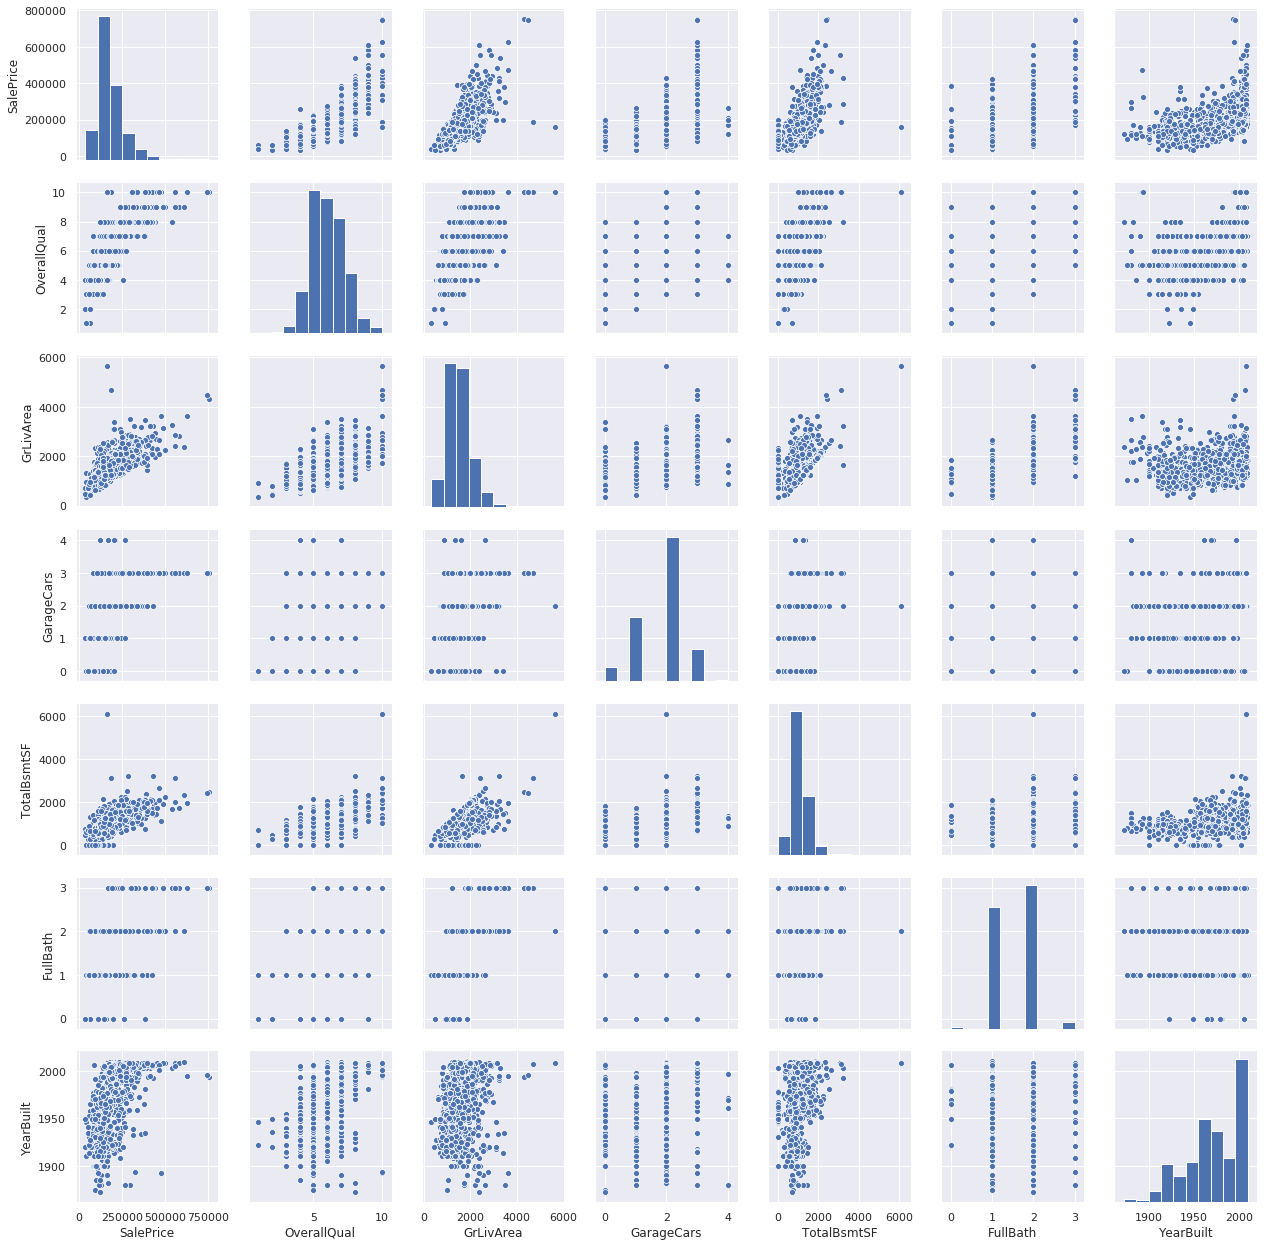

In [14]:
# scatterplot

sns.set()
cols = ['SalePrice', 'OverallQual', 'GrLivArea',
        'GarageCars', 'TotalBsmtSF', 'FullBath', 'YearBuilt']
sns.pairplot(df_train[cols], height=2.5)
plt.show()

### Missing Datas

In [15]:
total = df_train.isnull().sum().sort_values(ascending=False)
percent = (df_train.isnull().sum()/df_train.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
PoolQC,1453,0.995205
MiscFeature,1406,0.963014
Alley,1369,0.937671
Fence,1179,0.807534
FireplaceQu,690,0.472603
LotFrontage,259,0.177397
GarageCond,81,0.055479
GarageType,81,0.055479
GarageYrBlt,81,0.055479
GarageFinish,81,0.055479


In [16]:
# dealing with missing data

# Taking off the too many missing datas columns
df_train = df_train.drop((missing_data[missing_data['Total'] > 1]).index, 1)

# Taking off the one row missing data in Electrical
df_train = df_train.drop(df_train.loc[df_train['Electrical'].isnull()].index)

# just checking that there's no missing data missing...
df_train.isnull().sum().max()

0

### Outliers

In [19]:
# standardizing data

saleprice_scaled = StandardScaler().fit_transform(
    df_train['SalePrice'][:, np.newaxis])
low_range = saleprice_scaled[saleprice_scaled[:, 0].argsort()][:10]
high_range = saleprice_scaled[saleprice_scaled[:, 0].argsort()][-10:]
print('outer range (low) of the distribution:')
print(low_range)
print('\nouter range (high) of the distribution:')
print(high_range)

outer range (low) of the distribution:
[[-1.83820775]
 [-1.83303414]
 [-1.80044422]
 [-1.78282123]
 [-1.77400974]
 [-1.62295562]
 [-1.6166617 ]
 [-1.58519209]
 [-1.58519209]
 [-1.57269236]]

outer range (high) of the distribution:
[[3.82758058]
 [4.0395221 ]
 [4.49473628]
 [4.70872962]
 [4.728631  ]
 [5.06034585]
 [5.42191907]
 [5.58987866]
 [7.10041987]
 [7.22629831]]


We check again the scatterplots to look for outliers

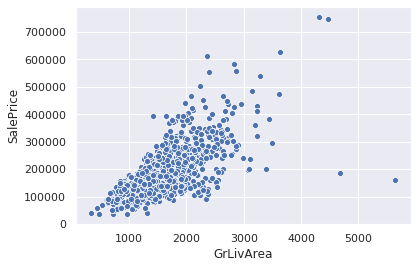

In [20]:
sns.scatterplot(x=df_train['GrLivArea'], y=df_train['SalePrice'])

The two points with high GrLivArea seems to be outliers however, the two highest points of SalePrice seems to be "in the line"

In [21]:
# deleting points
df_train.sort_values(by='GrLivArea', ascending=False)[:2]
df_train = df_train.drop(df_train[df_train['Id'] == 1299].index)
df_train = df_train.drop(df_train[df_train['Id'] == 524].index)

### Normality exploration

#### SalePrice

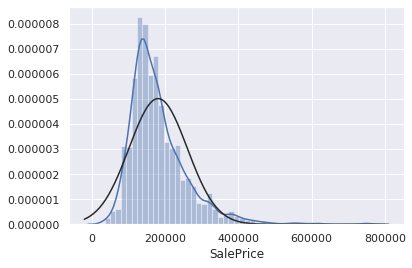

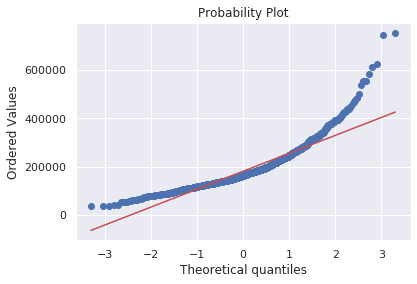

In [22]:
# histogram and normal probability plot
sns.distplot(df_train['SalePrice'], fit=norm)
fig = plt.figure()
res = stats.probplot(df_train['SalePrice'], plot=plt)

We see that `'SalePrice'` as a "big tail". We can avoid this by applying a `log` to it

In [23]:
# applying log transformation
df_train['SalePrice'] = np.log(df_train['SalePrice'])

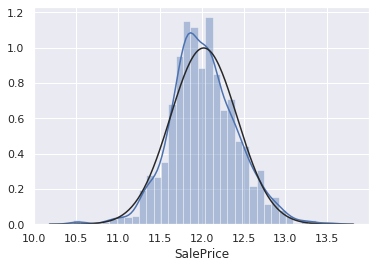

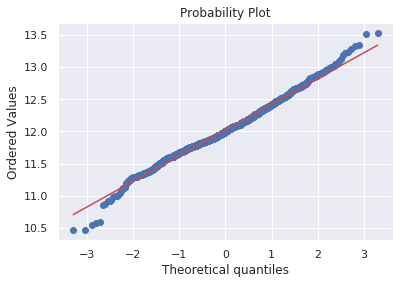

In [24]:
# transformed histogram and normal probability plot
sns.distplot(df_train['SalePrice'], fit=norm)
fig = plt.figure()
res = stats.probplot(df_train['SalePrice'], plot=plt)

That fits much better to a normal distribution

#### GrLivArea

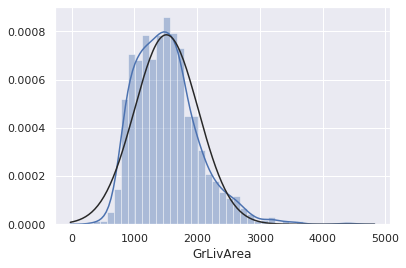

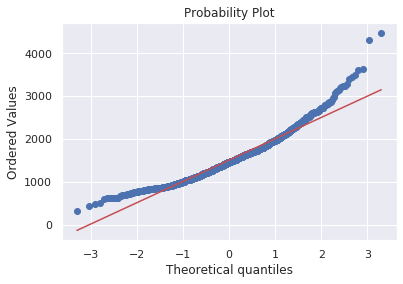

In [25]:
# histogram and normal probability plot
sns.distplot(df_train['GrLivArea'], fit=norm)
fig = plt.figure()
res = stats.probplot(df_train['GrLivArea'], plot=plt)

Same desease, same medecine:

In [26]:
# data transformation
df_train['GrLivArea'] = np.log(df_train['GrLivArea'])

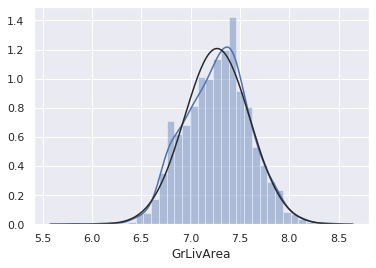

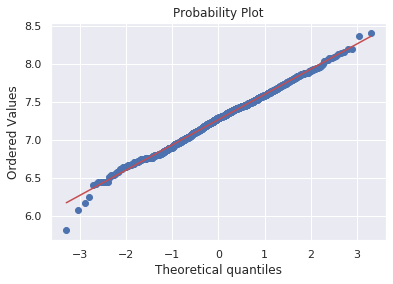

In [27]:
# transformed histogram and normal probability plot
sns.distplot(df_train['GrLivArea'], fit=norm)
fig = plt.figure()
res = stats.probplot(df_train['GrLivArea'], plot=plt)

#### TotalBsmtSF

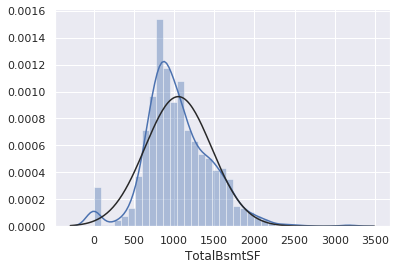

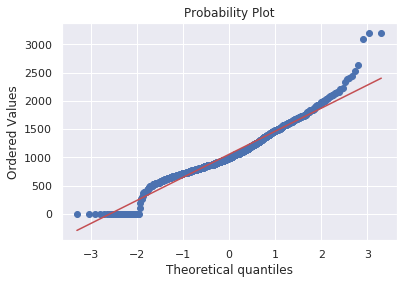

In [28]:
# histogram and normal probability plot
sns.distplot(df_train['TotalBsmtSF'], fit=norm)
fig = plt.figure()
res = stats.probplot(df_train['TotalBsmtSF'], plot=plt)

Because of the 0 presents in the dataset, we cannot use `log`. <br />
So we create a new binary feature that says if there's a basement or not

In [31]:
# create column for new variable (one is enough because it's a binary categorical feature)
# if area>0 it gets 1, for area==0 it gets 0
df_train['HasBsmt'] = pd.Series(
    len(df_train['TotalBsmtSF']), index=df_train.index)
df_train['HasBsmt'] = 0
df_train.loc[df_train['TotalBsmtSF'] > 0, 'HasBsmt'] = 1

In [32]:
# transform data
df_train.loc[df_train['HasBsmt'] == 1,
             'TotalBsmtSF'] = np.log(df_train['TotalBsmtSF'])

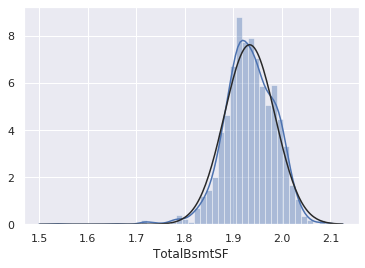

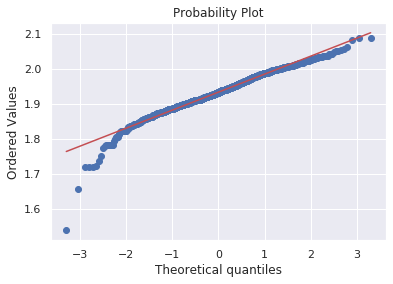

In [33]:
# histogram and normal probability plot
sns.distplot(df_train[df_train['TotalBsmtSF'] > 0]['TotalBsmtSF'], fit=norm)
fig = plt.figure()
res = stats.probplot(
    df_train[df_train['TotalBsmtSF'] > 0]['TotalBsmtSF'], plot=plt)

### homoscedasticity

#### 'SalePrice' and 'GrLivArea'

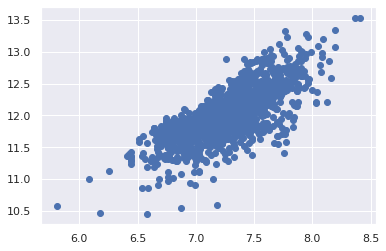

In [35]:
# scatter plot
plt.scatter(df_train['GrLivArea'], df_train['SalePrice'])

#### 'SalePrice' with 'TotalBsmtSF'

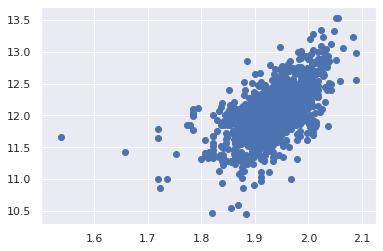

In [34]:
# scatter plot
plt.scatter(df_train[df_train['TotalBsmtSF'] > 0]['TotalBsmtSF'],
            df_train[df_train['TotalBsmtSF'] > 0]['SalePrice'])